In [2]:
#Import libraries
import pandas as pd
import numpy as np
import pickle
from ucimlrepo import fetch_ucirepo 
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from scipy.io import arff
import zipfile
import os

In [7]:
# Data Loader loads data from UCI-ML Repo
def load_dataset():
    # fetch dataset 
    solar_flare = fetch_ucirepo(id=89) 

    # data (as pandas dataframes) 
    x = solar_flare.data.features 
    y = solar_flare.data.targets 
    z = solar_flare.data.original

    # metadata 
    print(solar_flare.metadata) 

    # variable information 
    print(solar_flare.variables) 
    
    return x, y, z

# UCI-ML Repo Provides us with 3 Pandas DF inherently:
# 1. features (contains only the features)
# 2. targets (the targets to be preddicted)
# 3. original (contains both features and targets)
features, targets, original = load_dataset()

{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

In [18]:
def missing_value_analysis(dataset):
    missing_values = dataset.isnull().sum() # Count missing values for each column
    total_cells = dataset.shape[0] * dataset.shape[1] # Total number of cells in the dataset
    missing_percentage = (missing_values.sum() / total_cells) * 100 # Calculate the percentage of missing values
    
    print("Missing Values Analysis:")
    print("------------------------")
    print("Total Missing Values:")
    print(missing_values)
    print("\nTotal Missing Percentage: {:.2f}%".format(missing_percentage))

In [1]:
# Perform missing value analysis on the features dataset
missing_value_analysis(X)

# Perform missing value analysis on the targets dataset (if applicable)
missing_value_analysis(y)

NameError: name 'missing_value_analysis' is not defined

In [11]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

transform_data(original)

Categorical columns: Index(['modified Zurich class', 'largest spot size', 'spot distribution'], dtype='object')
Numerical columns: Index(['activity', 'evolution', 'previous 24 hour flare activity',
       'historically-complex', 'became complex on this pass', 'area',
       'area of largest spot', 'common flares', 'moderate flares',
       'severe flares'],
      dtype='object')


,modified Zurich class,largest spot size,spot distribution,activity,evolution,previous 24 hour flare activity,historically-complex,became complex on this pass,area,area of largest spot,common flares,moderate flares,severe flares
0,1,4,2,-0.420855,-0.682706,-0.223226,-0.809656,0.347945,-0.163118,2.166246,-0.3439,-0.191405,-0.090431
1,2,4,2,-0.420855,0.938283,-0.223226,-0.809656,0.347945,-0.163118,2.166246,-0.3439,-0.191405,-0.090431
2,1,4,2,-0.420855,0.938283,-0.223226,-0.809656,0.347945,-0.163118,-0.461628,-0.3439,-0.191405,-0.090431
3,2,4,2,-0.420855,0.938283,-0.223226,-0.809656,0.347945,-0.163118,2.166246,-0.3439,-0.191405,-0.090431
4,2,0,2,-0.420855,0.938283,-0.223226,-0.809656,0.347945,-0.163118,2.166246,-0.3439,-0.191405,-0.090431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,5,4,3,-0.420855,-0.682706,-0.223226,-0.809656,-2.874022,-0.163118,-0.461628,-0.3439,-0.191405,-0.090431
1385,5,4,3,2.376117,-0.682706,-0.223226,-0.809656,0.347945,-0.163118,-0.461628,-0.3439,-0.191405,-0.090431
1386,1,4,2,-0.420855,-0.682706,-0.223226,1.235093,0.347945,-0.163118,-0.461628,-0.3439,-0.191405,-0.090431
1387,5,3,3,-0.420855,-0.682706,-0.223226,-0.809656,0.347945,-0.163118,-0.461628,-0.3439,-0.191405,-0.090431


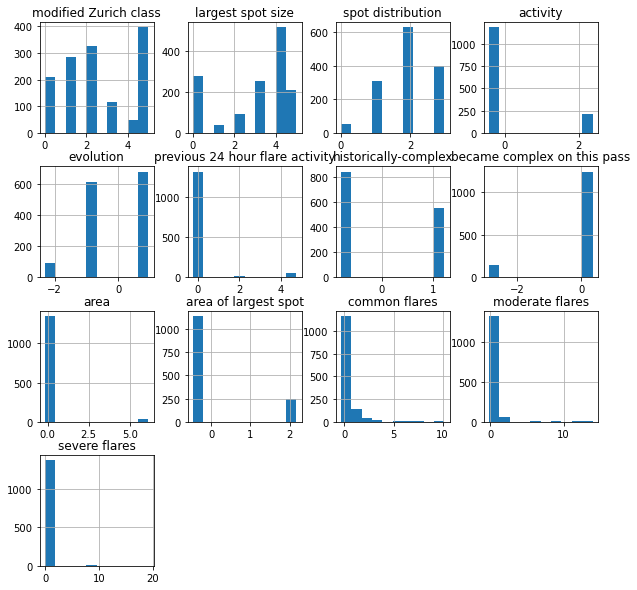

In [12]:
# Creates histograms for categorical data
def plot_histograms(df):
    df.hist(figsize=(10, 10))
    plt.show()

# Creates boxplot for numerical data
def plot_boxplots(df):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        sns.boxplot(x=df[col])
        plt.show()

plot_histograms(original)

In [13]:
# Performs data splitting on a 80:20 ratio
def split_data(df, target_name):
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Performs training and evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print("Accuracy:", accuracy_score(y_test, predictions))

{'uci_id': 89, 'name': 'Solar Flare', 'repository_url': 'https://archive.ics.uci.edu/dataset/89/solar+flare', 'data_url': 'https://archive.ics.uci.edu/static/public/89/data.csv', 'abstract': 'Each class attribute counts the number of solar flares of a certain class that occur in a 24 hour period', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1389, 'num_features': 10, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['common flares', 'moderate flares', 'severe flares'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5530G', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'Notes:\r\n\r\n   -- The database contains 3 potential classes, one for the number of times a certain type of solar flare occured in a 24 hour period.\r\n   -- Each instance represents captur

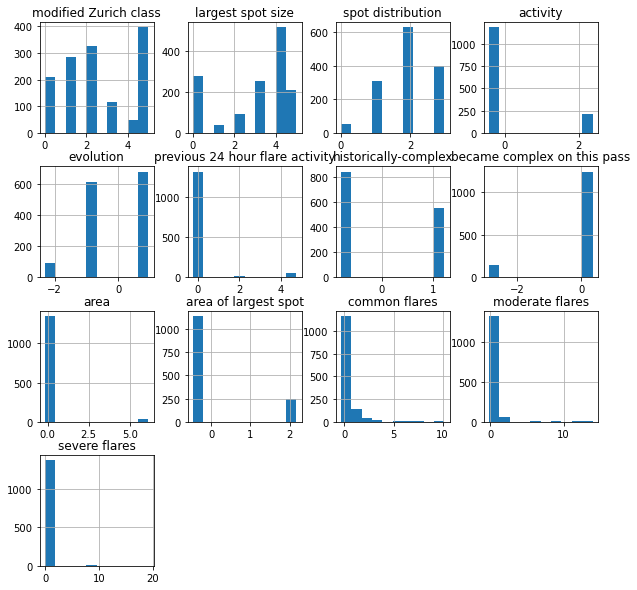

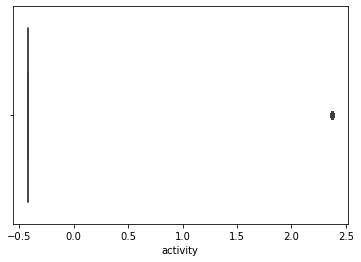

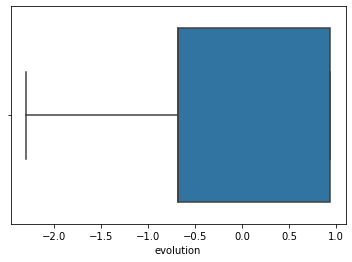

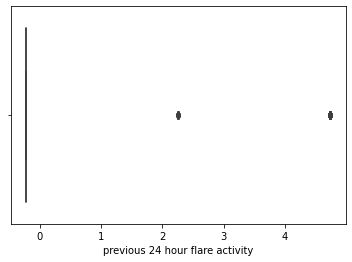

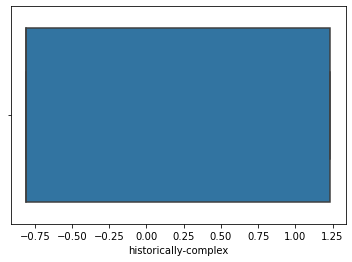

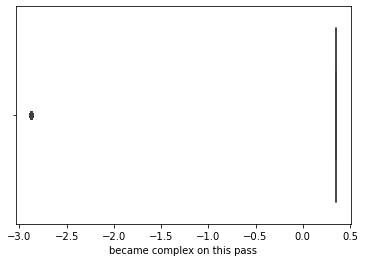

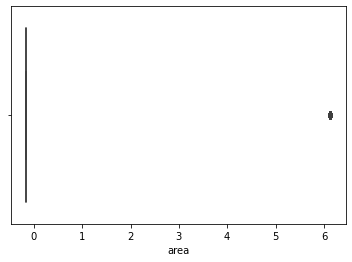

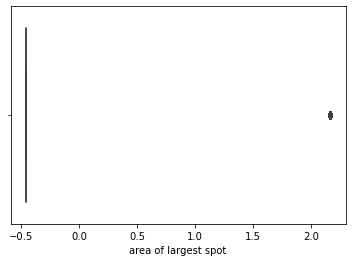

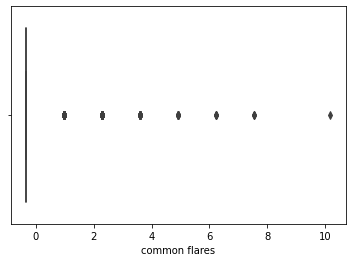

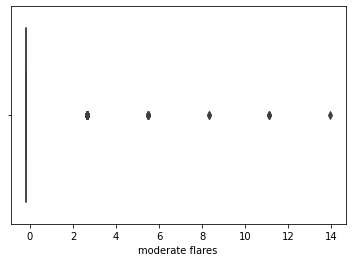

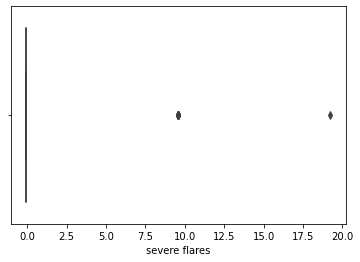

ValueError: Unknown label type: 'continuous'